May: How Mackenzie Canyon fits into the established scaling for depth of upwelling and upwelling flux.

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
from scipy import interpolate
from salishsea_tools import gsw_calls
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized

In [2]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/eventB_pulse10_bdy' 
gridT = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_T.nc')
gridU = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_U.nc')
gridV = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_V.nc')
gridW = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_W.nc')
mmask = xr.open_dataset(path+'/mesh_mask.nc')

In [3]:
nav_lat = np.asfarray(gridT['nav_lat'])
deptht = np.asfarray(gridT['deptht'])
u_vel = np.asfarray(gridU['vozocrtx'])
tmask = np.asfarray(mmask['tmask'])

In [4]:
initial_sal = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/salinity/salinity_doubled_20.nc')['vosaline']
initial_tem = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/temperature/temperature_doubled_20.nc')['votemper']

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'xtick.labelsize':11,
         'ytick.labelsize':11}
pylab.rcParams.update(params)

# Calculate N

The mean latitude and all depth levels are used to find the pressure profile. The pressure profile is used along with the initial salinity and temperature profiles were used to find the density, which was then used to find N.

In [8]:
dep = -1 * deptht
lat = np.ones(1) * np.mean(nav_lat)

print(dep.shape, lat.shape, lat)

p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [dep, lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

print(p)

(20,) (1,) [ 70.71705431]
[    5.0264    15.252     25.8       36.828     48.568     61.365     75.723
    92.379    112.4      137.29     169.14     210.75     265.7      338.2
   432.74     553.39     702.87     881.92    1089.      1320.8   ]


In [9]:
SA = initial_sal[0,:,0,0]
CT = initial_tem[0,:,0,0]

print(SA.shape, CT.shape, p.shape)

rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA, CT, p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

print(rho)

(20,) (20,) (20,)
[ 1017.7  1022.3  1023.3  1024.   1024.4  1025.   1025.7  1026.3  1026.9
  1027.6  1028.1  1028.6  1029.1  1029.5  1030.   1030.6  1031.3  1032.2
  1033.1  1034.3]


In [10]:
d_rho0 = np.diff(rho)
d_dep0 = np.diff(dep)

# diff does n+1 minus n so we lose the last derivative since there isn't an end+1 element
# we extrapolate to get the last hanging derivative
f_rho = interpolate.interp1d(np.arange(len(d_rho0)), d_rho0, fill_value='extrapolate')
f_dep = interpolate.interp1d(np.arange(len(d_dep0)), d_dep0, fill_value='extrapolate')

d_rho = f_rho(np.arange(len(d_rho0)+1))
d_dep = f_dep(np.arange(len(d_dep0)+1))

N = np.sqrt((-9.81 / rho)*(d_rho / d_dep))

print(N.shape, np.mean(N))

(20,) 0.0161591616779


# Incoming flow velocity

For now, the rim is assumed to be at 80 m depth. Later, I should find the depth along the sloping rim and match it with a higher resolution depth level profile. For now, depths are still course so it's between 74 m (ind=6) and 91 m (ind=7). I've chosen the x_ind and have found a y_ind using x_ind and rim_ind, however I've added a few points to y_ind. The incoming velocity has a lot of "teeth" so I smoothed the signal using a [moving average function](https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way).

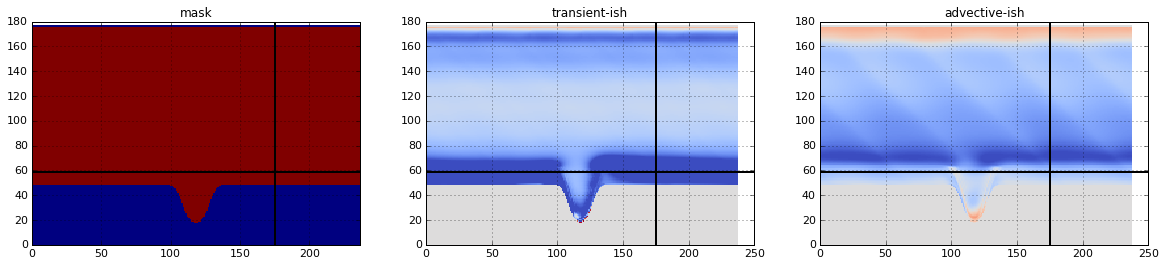

In [22]:
# I set the x index for the alongshore incoming flow
x_ind = 175
# I am also defining the rim depth as a hard depth level 
rim_ind = 6
# I find the first water index from the shelf
# That is really close so I add a few more steps offshore
y_ind = np.where(tmask[0,rim_ind,:,x_ind]==1)[0][0] + 10

# -----------------------------------------------------------------------

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.pcolor(tmask[0,rim_ind,:,:])
ax1.set_xlim(0,tmask.shape[-1])

time_ind_ax2, time_ind_ax3 = 75, 420 #random times early/late
ax2.pcolor(u_vel[time_ind_ax2, rim_ind, :, :], cmap='coolwarm', vmin=-0.05, vmax=0.05)
ax3.pcolor(u_vel[time_ind_ax3, rim_ind, :, :], cmap='coolwarm', vmin=-0.05, vmax=0.05)

ax1.axvline(x_ind, lw=2, c='k'); ax1.axhline(y_ind, lw=2, c='k'); ax1.grid(); ax1.set_title('mask')
ax2.axvline(x_ind, lw=2, c='k'); ax2.axhline(y_ind, lw=2, c='k'); ax2.grid(); ax2.set_title('transient-ish')
ax3.axvline(x_ind, lw=2, c='k'); ax3.axhline(y_ind, lw=2, c='k'); ax3.grid(); ax3.set_title('advective-ish')

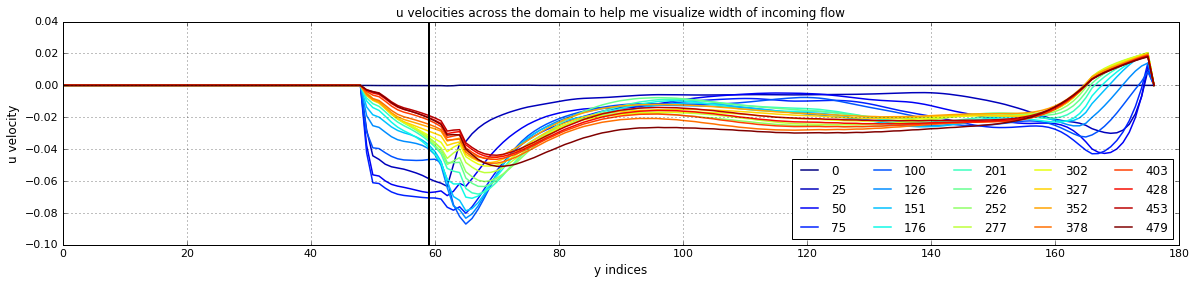

In [23]:
num_lines = 20
time_inds = np.linspace(0, u_vel.shape[0]-1, num_lines)

# -----------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
cms = np.linspace(0, 1, num_lines)
cs = [ cm.jet(x) for x in cms]
for n in range(num_lines):
    time_ind = int(time_inds[n])
    ax.plot(u_vel[time_ind, rim_ind, :, x_ind], color = cs[n], label=str(time_ind), lw=1.5)
ax.legend(ncol = 5, loc=4)
ax.grid()
ax.axvline(y_ind, lw=2, c='k')
ax.set_xlabel('y indices')
ax.set_ylabel('u velocity')
ax.set_title('u velocities across the domain to help me visualize width of incoming flow')

-0.0243451753503


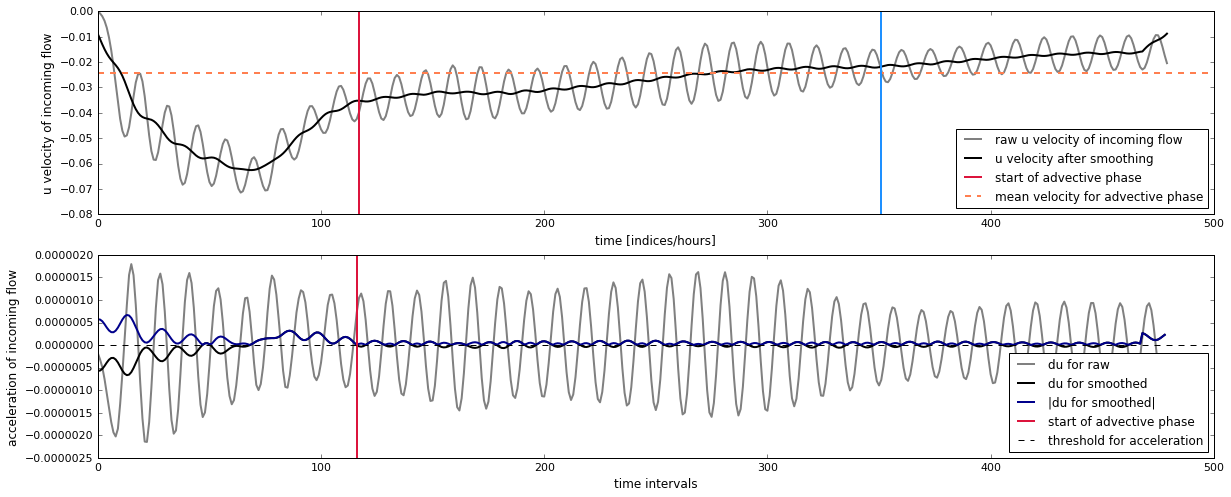

In [55]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# We want to find the acceleration of the incoming flow to set transient/advective
# Incoming velocity is smoothed to eliminate weird oscillations in derivative
u_in = u_vel[:, rim_ind, y_ind, x_ind]
# The box_pts values can be changed
u_in_smooth = smooth(u_in, 24)

# Anything below this threshold will be considered to not be accelerating (steady - advective)
vel_threshold = 1e-8
# However, there is zero acceleration at the peak of the velocity bump
# So, I find where acceleration is zero for longer than 24 hours
permanent_duration = 24
# iodef write time step (1 hour currently)
dt = 1 * 60 *60

# -----------------------------------------------------------------------
# 
# This is the derivative of the raw incoming velocity (but, it's too jagged)
du_in = np.diff(u_in) / dt
# The derivative of the smoothed shows a clearer acceleration pattern
du_in_smooth = np.diff(u_in_smooth) / dt
# I simplify the thought process by making all velocities positive
du_in_smooth_abs = abs(du_in_smooth)

# -----------------------------------------------------------------------

# This gives all values below the threshold (closest to 0), including at the bump
inds_below_threshold = np.where(du_in_smooth_abs < vel_threshold)[0]
# The inds at the bump will have a spacing of 1 but only for a few steps
# I want to find when the spacing goes to 1 for a longer/permanent period of time
spacing_inds = np.diff(inds_below_threshold)
# This finds the index after a lul longer than 24 hours
# The 1 is added because of the diff
subind_permanent_steady = np.where(spacing_inds > permanent_duration)[0][0] + 1
# This is the time index where the advection stage begins in the du calculculation
time_ind_adv_du = inds_below_threshold[subind_permanent_steady]
# du_ind belongs to u_ind+1 and u_ind, so to be safe I'll take u_ind+1 as the start
time_ind_adv = time_ind_adv_du + 1

# -----------------------------------------------------------------------

# Mean incoming velocity for the advective phase
# Using the unsmoothed velocity
U_incoming = np.mean(u_in[time_ind_adv:])

# -----------------------------------------------------------------------

x = np.arange(len(u_in))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
ax1.plot(x, u_in, lw=2, c='gray', label='raw u velocity of incoming flow')
ax1.plot(x, u_in_smooth, lw=2, c='k', label='u velocity after smoothing')
ax1.axvline(time_ind_adv, lw=2, c='crimson', label='start of advective phase')
ax1.axhline(U_incoming, lw=2, c='coral', linestyle='--', label='mean velocity for advective phase')
ax1.legend(ncol=1, loc=4)
ax1.set_xlabel('time [indices/hours]')
ax1.set_ylabel('u velocity of incoming flow')
ax1.axvline(end_adv, lw=2, c='dodgerblue', label='end of advective phase')

ax2.plot(du_in, lw=2, c='gray', label='du for raw')
ax2.plot(du_in_smooth, lw=2, c='k', label='du for smoothed')
ax2.plot(du_in_smooth_abs, lw=2, c='darkblue', label='|du for smoothed|')
ax2.axvline(time_ind_adv_du, lw=2, c='crimson', label='start of advective phase')
ax2.axhline(vel_threshold, c='k', linestyle='--', label='threshold for acceleration')
ax2.legend(ncol=1, loc=4)
ax2.set_xlabel('time intervals')
ax2.set_ylabel('acceleration of incoming flow')

print(U_incoming)

# Calculating $R_0 = U / f\cal{R}$
### Rossby number
* strength of velocity upstream of canyon
* Coriolis parameter
* $\cal{R}$: radius of curvature of shelf break isobaths upstream of canyon

To be cautious, I would check the radius of curvature again once I change the resolution of the domain. This would be done in bathymetry/radius_of_curvature.ipynb.

In [56]:
lat = np.mean(nav_lat)
omega = (2 * np.pi) / (24 * 60 * 60)
f = 2 * omega * np.sin(np.deg2rad(lat))

In [57]:
# from radius_of_curvature.ipynb
curv_rad_km = 42.584509999999995 # AHp8, pretty big, Quinault = 44.0km
curv_rad = curv_rad_km * 1000 

In [58]:
R0 = abs(U_incoming) / (f * curv_rad)

print(R0) #AHp10 very small, Quinault = 0.04

0.00416427567662


# Calculating $\cal{F}$$(R_0) = R_0 / 0.9 + R_0$
### Function of $R_0$ 
* Rossby number

In [59]:
F_R0 = R0 / (0.9 + R0)

print(F_R0) #AHp10 very small, Quinault = 0.05

0.0046056626972


# Calculating $R_L = U / fL$
### Rossby number
* Length of the canyon

The values that are hard coded into functions_idealized are: length, widths at break/mid/head, full depths and the various depth steps.

In [60]:
x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

print(L)
print(w_break)
print(z_paral, z_pointA)

98000
62681.73577685928
475.0 921.0


In [61]:
RL = abs(U_incoming) / (f * L)

print(RL) #AHp10 very small, Carson = 0.06, Astoria = 0.09

0.00180952693055


# Calculating $D_H = fL/N$
### Depth scale
* Brunt-Vaisala frequency near rim depth

In [62]:
DH = (f * L) / N[rim_ind]

print(DH) #AHp8 big, Astoria = 305, Quinalt = 237

720.992379406


# Calculating $Z/D_H = 1.3 ($$\cal{F}$$R_L)^{1/2} + 0.06$
### (Allen and Hickey 2010) Vertical depth change of deepest isopycnal upwelled onto shelf
* DH: depth scale
* F_R0: function of R0
* RL: Rossby number
* U: strength of velocity upstream of the canyon
* N: Brunt-Vaisala frequency near rim depth
* L: length of the canyon
* $\cal{R}$: radius of curvature of shelf break isobath upstream of canyon

In [63]:
Z_form = DH * (F_R0 * RL)**0.5

Z_AH10 = DH * ((1.3 * (F_R0 * RL)**0.5) + 0.06)

Z_simplif = 1.4 * (abs(U_incoming) / N[rim_ind]) * ((L / curv_rad)**0.5)

print(Z_AH10)

45.9653859038


# Calculating $R_W = U / f$ $\cal{R}$ $_W$
### Rossby number
* $\cal{R}_W$ : width of canyon at half length measured at shelf-break isobath

In [64]:
RW = abs(U_incoming) / (f * w_mid)

print(RW) #HAp10 half slope extra low U = 0.18+-0.03

0.00381715901239


# Calculating $\cal{F}$ $_W = R_W / 0.9 + R_W$
### Function of $R_W$

In [65]:
F_RW = RW / (0.9 + RW)

print(F_RW) #HAp10 half slope extra low U = 0.17+-0.002

0.00422337524169


# Calculating $s = (H_w - H_s)/(r_w - r_s)$
### Continental shelf slope
The topographic slope from the coast to the shelf break

In [66]:
s = (z_coast - z_break) / (y_coast - y_break)

print(s, z_coast - z_break, y_coast - y_break)

0.0003343568550117787 40.0 119632.6601367


# Calculating $S_E = sN/f * ($$\cal{F}$$_W / R_L)^{1/2}$
### Non-dimensional slope effect

In [67]:
SE = (s * N[rim_ind] / f) * ((F_RW / RL)**0.5)

print(SE)

0.0694309235565


# Calculating $Z/D_H = 1.8 ($ $\cal{F}$ $_WR_L)^{1/2} (1-0.42 S_E) + 0.05$

In [68]:
Z_HA13 =  DH * (1.8 * ((F_RW * RL)**0.5) * (1 - (0.42 * SE)) + 0.05)

print(Z_HA13)

39.5326934362
